<h1 style="text-align: center;">Hotel booking cancellation prediction</h1>

## 1. Project overview

This is the final project for DTSA 5509 (Supervised Learning). 

### About the data
The dataset I used is originally from [Hotel Booking Demand Datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191#t0005), and it can be downloaded from [Kaggle](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data). The data was extracted from hotels’ Property Management System (PMS) SQL databases, containing hotel booking information in Portugal from July 1, 2015 to August 31, 2017.

### Objective
In this project, I am going to use supervised learning methods to predict whether or not a hotel booking was likely to be canceled in the future. First I will train a Decision Tree Classifier model, and evaluate how well it predicts later cancellations based on all the information available at the time of booking. Also using this Decision Tree Classifier model as a baseline, I would compare several ensemble methods to see which one performs better on this dataset.

## 2. Exploratory Data Analysis (EDA) 

### Data inspection

This dataset includes 118898 samples and 32 variables. To train the predictive model, I select the "is_canceled" column as the label column, the the other 31 columns as features. These columns are defined below.

| Column | Description |
| :----------- | :----------- |
| hotel | H1 = Resort Hotel or H2 = City Hotel |
| is_canceled | The booking was canceled (1) or not (0) | 
| lead_time | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date |
| arrival_date_year | Year of arrival date |
| arrival_date_month | Month of arrival date |
| arrival_date_week_number | Week number of year for arrival date |
| arrival_date_day_of_month | Day of arrival date |
| stays_in_weekend_nights | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
| stays_in_week_nights | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel |
| adults | Number of adults |
| children | Number of children |
| babies | Number of babies |
| meal | Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner) |
| country | Country of origin |
| market_segment | In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| distribution_channel | The term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| is_repeated_guest |  a repeated guest (1) or not (0) |
| previous_cancellations | Number of previous bookings that were cancelled by the customer prior to the current booking |
| previous_bookings_not_canceled | Number of previous bookings not cancelled by the customer prior to the current booking |
| reserved_room_type | Code of room type reserved. Code is presented instead of designation for anonymity reasons |
| assigned_room_type | Code for the type of room assigned to the booking.|
| booking_changes | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| deposit_type | No Deposit; Non Refund; Refundable. |
| agent | ID of the travel agency that made the booking |
| company | ID of the company/entity that made the booking or responsible for paying the booking.  |
| days_in_waiting_list | Number of days the booking was in the waiting list before it was confirmed to the customer |
| customer_type | Contract: when the booking has an allotment or other type of contract associated to it; Group: when the booking is associated to a group; Transient: when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party: when the booking is transient, but is associated to at least other transient booking |
| adr | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
| required_car_parking_spaces | Number of car parking spaces required by the customer |
| total_of_special_requests | Number of special requests made by the customer (e.g. twin bed or high floor) |
| reservation_status | Canceled: booking was canceled by the customer; Check-Out: customer has checked in but already departed; No-Show: customer did not check-in and did inform the hotel of the reason why |
| reservation_status_date | Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel |

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/hotel_bookings.csv')

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Data Cleaning

#### Drop features

Through inspecting the data, the "market_segment" and "distribution_channel" have duplicate or confusing values. And "agent" and "company" features are not meaningful. In addition, the features "is_canceled" and "arrival_date*" already provide enough information, and we do not need repeated supplementary information for "reservation_status" and "reservation_status_date". So we drop these columns.

In [4]:
df = df.drop(columns=['market_segment','distribution_channel','agent','company',
                      'reservation_status','reservation_status_date'])
df = df.dropna()

#### Convert all object datatype to categorical

For correlation analysis, all features should have a datatype of int or float. Therefore we need to convert all features with object datatype to categorical numbers.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118898 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118898 non-null  object 
 1   is_canceled                     118898 non-null  int64  
 2   lead_time                       118898 non-null  int64  
 3   arrival_date_year               118898 non-null  int64  
 4   arrival_date_month              118898 non-null  object 
 5   arrival_date_week_number        118898 non-null  int64  
 6   arrival_date_day_of_month       118898 non-null  int64  
 7   stays_in_weekend_nights         118898 non-null  int64  
 8   stays_in_week_nights            118898 non-null  int64  
 9   adults                          118898 non-null  int64  
 10  children                        118898 non-null  float64
 11  babies                          118898 non-null  int64  
 12  meal                 

In [6]:
# Convert "arrival_date_month" datatype to numbers
d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 
     'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
df.arrival_date_month = df.arrival_date_month.map(d)

# Convert all object type columns to categorical
for col_name in df.columns:
    if(df[col_name].dtype == 'object'):
        df[col_name]= df[col_name].astype('category')
        df[col_name] = df[col_name].cat.codes

In [7]:
# Move column "is_canceled" to the first column
first_column = df.pop('is_canceled') 
df.insert(0, 'is_canceled', first_column) 
display(df)

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,1,342,2015,7,27,1,0,0,2,...,0,2,2,3,0,0,2,0.00,0,0
1,0,1,737,2015,7,27,1,0,0,2,...,0,2,2,4,0,0,2,0.00,0,0
2,0,1,7,2015,7,27,1,0,1,1,...,0,0,2,0,0,0,2,75.00,0,0
3,0,1,13,2015,7,27,1,0,1,1,...,0,0,0,0,0,0,2,75.00,0,0
4,0,1,14,2015,7,27,1,0,2,2,...,0,0,0,0,0,0,2,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,0,23,2017,8,35,30,2,5,2,...,0,0,0,0,0,0,2,96.14,0,0
119386,0,0,102,2017,8,35,31,2,5,3,...,0,4,4,0,0,0,2,225.43,0,2
119387,0,0,34,2017,8,35,31,2,5,2,...,0,3,3,0,0,0,2,157.71,0,4
119388,0,0,109,2017,8,35,31,2,5,2,...,0,0,0,0,0,0,2,104.40,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118898 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118898 non-null  int64  
 1   hotel                           118898 non-null  int8   
 2   lead_time                       118898 non-null  int64  
 3   arrival_date_year               118898 non-null  int64  
 4   arrival_date_month              118898 non-null  int64  
 5   arrival_date_week_number        118898 non-null  int64  
 6   arrival_date_day_of_month       118898 non-null  int64  
 7   stays_in_weekend_nights         118898 non-null  int64  
 8   stays_in_week_nights            118898 non-null  int64  
 9   adults                          118898 non-null  int64  
 10  children                        118898 non-null  float64
 11  babies                          118898 non-null  int64  
 12  meal                 

#### Data Cleaning Summary
As can be seen above, after removing all duplicate, cluttered, redundant and null values, and munging the data types, now  the new dataset has a size of 118898 rows and 26 columns. That means we have 118898 samples, and 25 features plus 1 label ("is_cancelled"). Moreover, the data types of all features and label are unified to numerical datatype.

### Data Visualization

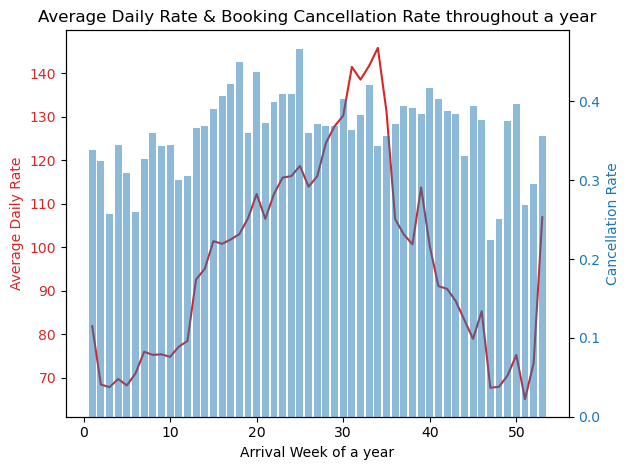

In [9]:
fig, ax1 = plt.subplots()
ax1.set_title("Average Daily Rate & Booking Cancellation Rate throughout a year")

color = 'tab:red'
ax1.set_xlabel('Arrival Week of a year')
ax1.set_ylabel('Average Daily Rate', color=color)
ax1.plot(df.groupby(['arrival_date_week_number']).agg({'adr':['mean']}), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df1 = df.groupby(['arrival_date_week_number']).agg({'is_canceled': ['count', 'sum']})
df1["cancellation_rate"] = df1[("is_canceled","sum")]/df1[("is_canceled", "count")]
df1.drop([("is_canceled","sum"), ("is_canceled", "count")], axis=1)

color = 'tab:blue'
ax2.set_ylabel('Cancellation Rate', color=color) 
ax2.bar(df1.index, df1["cancellation_rate"], color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

As can be seen from the figure, the highest daily rates throughout a year are concentrated in the summer (around week 27 to 35).However, the cancellation rate in summer declined slightly compared to adjacent periods. This makes sense since more difficulty and more expensive in booking a hotel room would result in higher cancellation costs.

#### Use heat map to visualize the correlation matrix

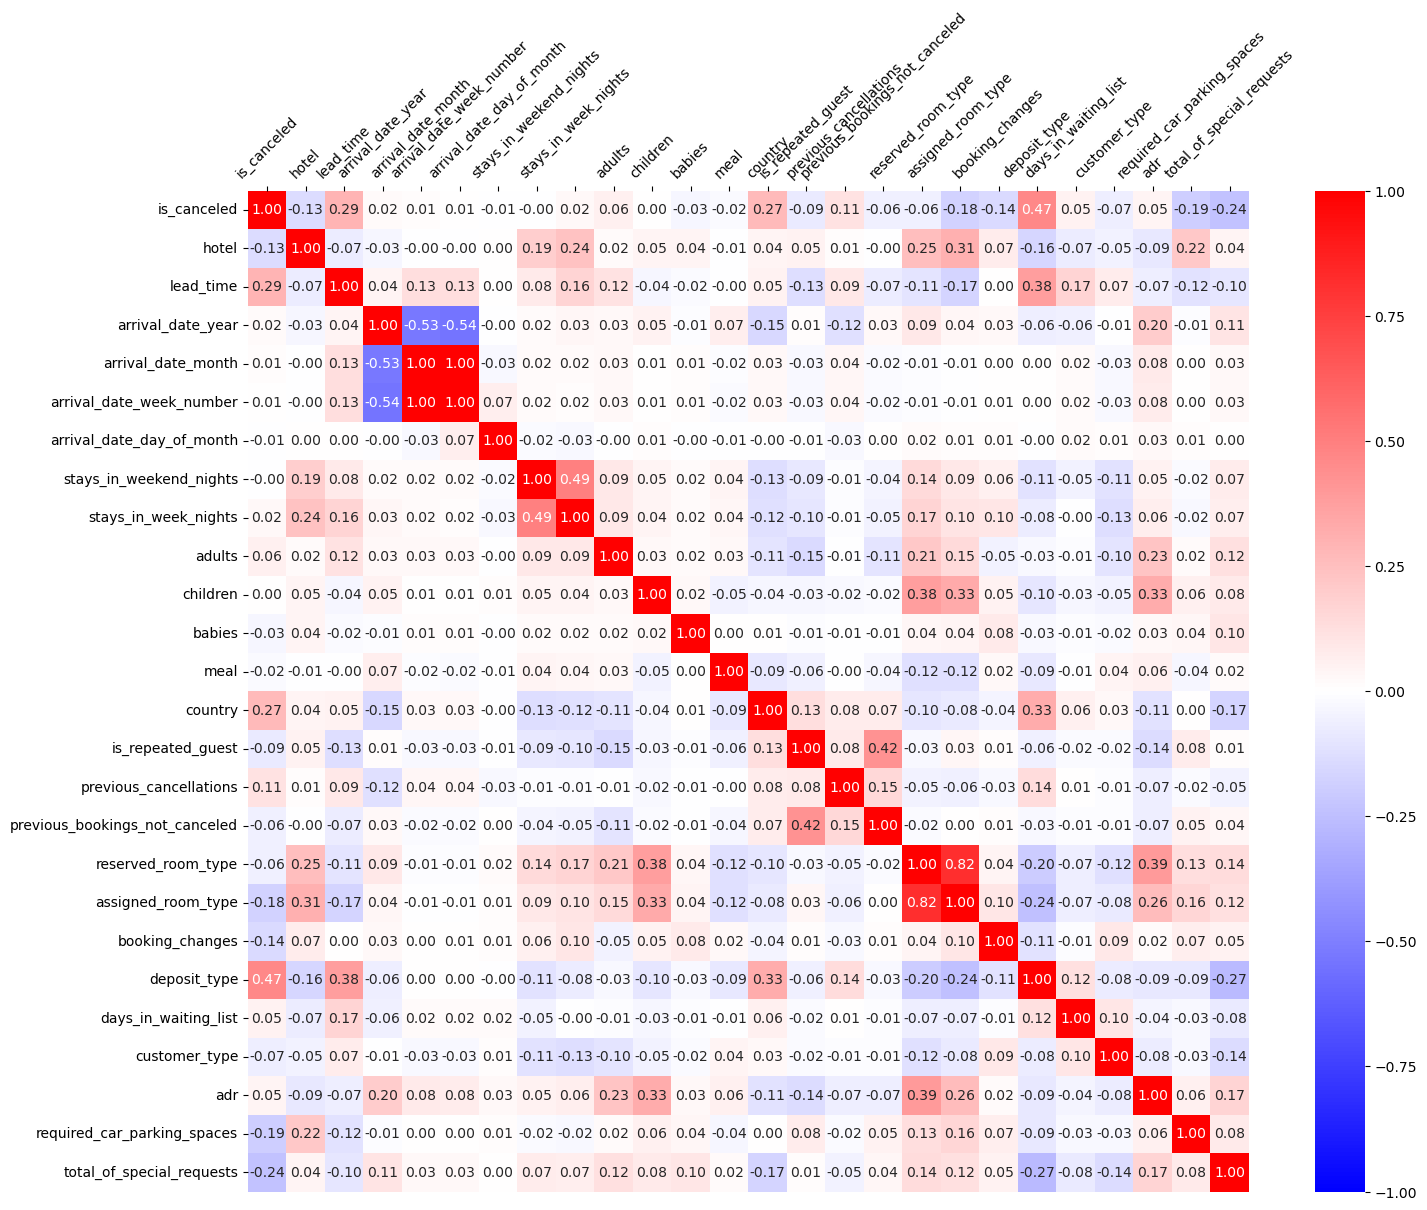

In [10]:
hm = sns.heatmap(data=df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='bwr', square=True, yticklabels=1)
hm.figure.set_size_inches(17, 13)
hm.xaxis.tick_top()
plt.xticks(rotation=45)
plt.savefig("correlation_heatmap.png")

Looking at the correlation matrix, there is no high correlation greater than 0.7, which means that all these features are not collinear. Feature "deposit_type" is most correlated with "is_canceled" label (correlation = 0.47). Other correlated features include "lead_time" (correlation = 0.29) and "country" (correlation = 0.27).

Below are the plots of the relationship between deposit type and cancellation rate. The values for "deposit_type" include "No Deposit", "Non Refund" and "Refundable". These visualizations show that the "Non refund" deposit type has the highest cancellation rate, while the most common deposit type, "No Deposit", has a much lower cancellation rate. This may seem counterintuitive, but here is what the data tells us.

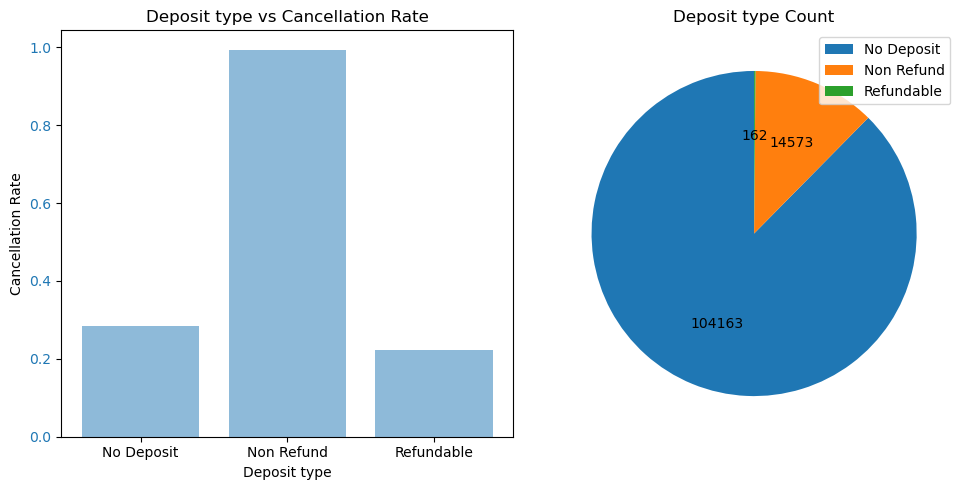

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10, 5))
ax[0].set_title("Deposit type vs Cancellation Rate")
ax[0].set_xlabel('Deposit type')
ax[0].set_ylabel('Cancellation Rate') # color='tab:blue'
df1 = df.groupby(['deposit_type']).agg({'is_canceled': ['count', 'sum']})
df1["cancellation_rate"] = df1[("is_canceled","sum")]/df1[("is_canceled", "count")]
ax[0].bar(df1.index, df1["cancellation_rate"], color=color, alpha=0.5)
ax[0].tick_params(axis='y', labelcolor=color)
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(["No Deposit", "Non Refund", "Refundable"])

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{absolute:d}"
  
ax[1].set_title("Deposit type Count")
wedges, texts, autotexts = ax[1].pie(df1[("is_canceled", "count")], 
          autopct=lambda pct: func(pct, df1[("is_canceled", "count")]), startangle=90)
ax[1].legend(wedges, ["No Deposit", "Non Refund", "Refundable"],
          loc="best",
          )

fig.tight_layout()
plt.show()

#### Exploratory Data Analysis (EDA) summary
During the EDA process, I first inspected the data thoroughly and selected the "is_cancelled" column as the label and the other columns as features. I then carefully go through the data cleaning process, filtering out cluttered or redundant data, removing NA values, and converting data types so that all features have numeric data types for further analysis.

Next, I analyzed the data through multiple visualizations to gain a comprehensive understanding of the data. And here are what I found:

- The highest average daily rate for a hotel booking occurs in summer, but the peak cancellation rate occurs before and after this time period.
- From the correlation matrix, all the features are not collinear. Some features such as "deposit_type", "lead_time", "country" have certain correlations with cancellation.
- There is also an interesting findings in the analysis between deposit type and cancellation rate. Non-refundable deposit type has a higher cancellation rate than no deposit type. Although it is different from intuition, we need to accept the facts of the data. This could be another interesting data mining project. But for this project, we will still focus on cancellation prediction.

## 3. Modeling

Although during the EDA process I found that several features are more related to cancellation than others, cancellation situations are more complex and require more features to be considered. Therefore in the modeling part, I will incorporate all the features into my supervised machine learning training.

Since my goal is to make a prediction on whether or not a cancellation will happen, I will develop classification models.

### Data preparation

In order to develop a model with higher prediction accuracy for the likelihood of booking cancellation, I split the data into train and test datasets, so that 80% of the randomly selected samples will be used to train the model, and the remaining 20% of the data will be retained for testing model accuracy.

In [12]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

### Decision Tree Classifier -- post pruning tree

First I will build a Decision Tree Classifier. To prevent overfitting, I want to develop a complete tree and then post-prun it using the hyperparameter "ccp_alpha". So the following is an exploration to find the best value of ccp_alpha.

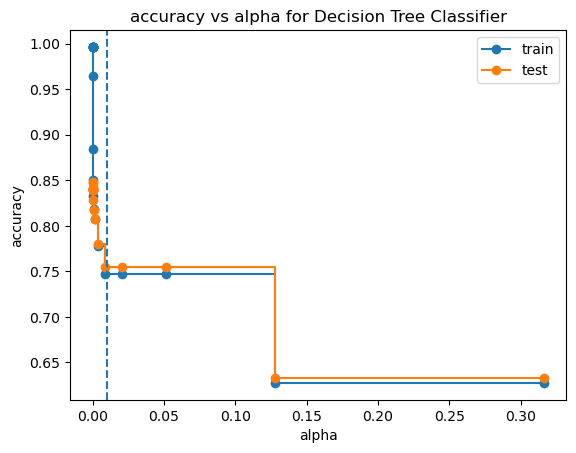

In [13]:
DecisionTreeclf = DecisionTreeClassifier().fit(X_train, y_train)

# Explore the best value of ccp_alpha in post pruning
ccp_alphas= list(np.logspace(-8,-0.5,20))

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = []
test_scores = []
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs alpha for Decision Tree Classifier")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.axvline(x=0.01, ls="--")
ax.legend()
plt.show() 

From the plot, I set parameter ccp_alpha=0.01 in DecisionTreeClassifier to train the model, and then visualize the final tree, and plot the ROC curve to see how well the model does.

In [14]:
DecisionTreeclf = DecisionTreeClassifier(ccp_alpha=0.01).fit(X_train, y_train)

print("Decision Tree Accuracy:", DecisionTreeclf.score(X_test, y_test))

Decision Tree Accuracy: 0.7547098402018503


[Text(0.6, 0.9, 'x[19] <= 0.5\ngini = 0.467\nsamples = 95118\nvalue = [59689, 35429]'),
 Text(0.4, 0.7, 'x[1] <= 11.5\ngini = 0.409\nsamples = 83386\nvalue = [59526, 23860]'),
 Text(0.2, 0.5, 'gini = 0.199\nsamples = 18657\nvalue = [16564, 2093]'),
 Text(0.6, 0.5, 'x[12] <= 133.5\ngini = 0.446\nsamples = 64729\nvalue = [42962, 21767]'),
 Text(0.4, 0.3, 'x[21] <= 2.5\ngini = 0.385\nsamples = 43218\nvalue = [31958, 11260]'),
 Text(0.2, 0.1, 'gini = 0.432\nsamples = 34382\nvalue = [23517, 10865]'),
 Text(0.6, 0.1, 'gini = 0.085\nsamples = 8836\nvalue = [8441, 395]'),
 Text(0.8, 0.3, 'gini = 0.5\nsamples = 21511\nvalue = [11004, 10507]'),
 Text(0.8, 0.7, 'gini = 0.027\nsamples = 11732\nvalue = [163, 11569]')]

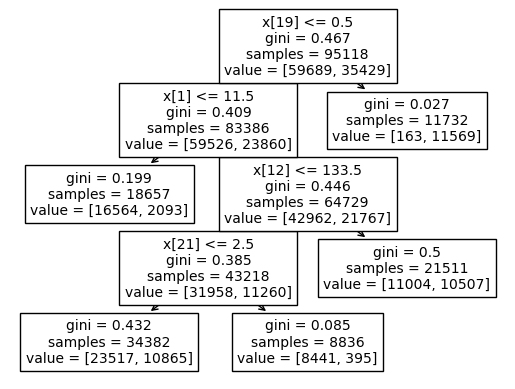

In [15]:
# Visualize the tree
tree.plot_tree(DecisionTreeclf.fit(X_train, y_train))

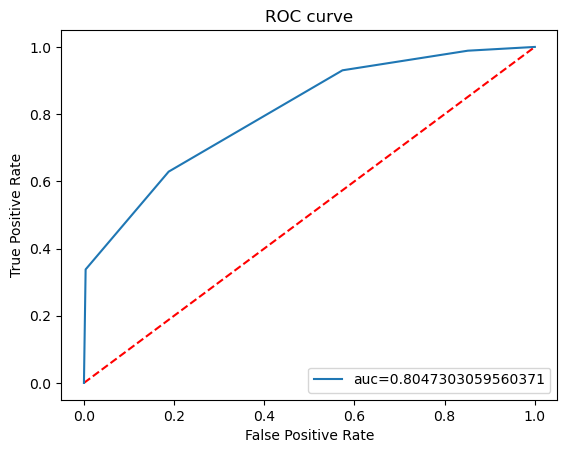

In [16]:
# Plot the ROC curve ( True positive rate vs False positive rate) 

y_pred_proba = DecisionTreeclf.predict_proba(X_test)[:,1]

fpr, tpr, th = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'r--')

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

The ROC curve shows that the Decision Tree Classifier performs well (test accuracy 75%, AUC 80%). However this is not good enough. To further prevent overfitting, I wanted to explore several Ensemble methods of boosting trees and evaluate whether I could significantly improve accuracy.

### Parameter selection -- GridSearchCV
Based on the Decision Tree generated above, I would like to try several ensemble methods, such as Gradient Boosting Classifier, Random Forest Classifier and AdaBoost Classifier. And, I will compare their performance on the data.

Since classification models have many parameters, GridSearchCV is a great way to optimize parameter selection via cross-validated grid-search. I will apply GridSearchCV in the emsemble models to find the optimal parameter combinations.

In [17]:
from sklearn.model_selection import GridSearchCV

### Gradient Boosting Classifier

In [18]:
grid_GB = GridSearchCV(estimator = GradientBoostingClassifier(),
                       param_grid = {'max_features': ['sqrt', 'log2', 0.8, None],
                                     'max_depth': [3,5,10,30,None],
                                     'ccp_alpha': [0, 0.01, 0.05, 0.1],
                                    },
                       scoring = 'accuracy',
                       cv = 5,
                       n_jobs = -1
                      )
grid_GB.fit(X_train,y_train)
print ("Gradient Boosting best parameters: ", grid_GB.best_params_)
print ("Gradient Boosting Accuracy:", grid_GB.best_score_)

Gradient Boosting best parameters:  {'ccp_alpha': 0, 'max_depth': 30, 'max_features': 'sqrt'}
Gradient Boosting Accuracy: 0.8809689259122251


### Random Forest Classifier

In [19]:
grid_RF = GridSearchCV(estimator = RandomForestClassifier(),
                       param_grid = {'max_features': ['sqrt', 'log2', 0.8, None],
                                     'max_depth': [3,5,10,30,None],
                                     'ccp_alpha': [0, 0.01, 0.05, 0.1],
                                    },
                       scoring = 'accuracy',
                       cv = 5,
                       n_jobs = -1
                      )
grid_RF.fit(X_train,y_train)
print ("Random Forest best parameters: ", grid_RF.best_params_)
print ("Random Forest Accuracy:", grid_RF.best_score_)

Random Forest best parameters:  {'ccp_alpha': 0, 'max_depth': None, 'max_features': 'log2'}
Random Forest Accuracy: 0.8807691472767661


### AdaBoost Classifier

In [20]:
Adaclf = AdaBoostClassifier(n_estimators=150, algorithm="SAMME").fit(X_train, y_train)
print("Adaboost Accuracy:", Adaclf.score(X_test, y_test))

Adaboost Accuracy: 0.8045416316232128


### Performance Comparison

In [21]:
n_trees = [10,20,50,100,200,500,1000]
DecisionTree_acc = []
Ada_acc = []
GB_acc = []
RF_acc = []

for i in n_trees:
  
  # Accuracy for Decision_Tree Classifier (baseline)
  DecisionTree_acc.append(DecisionTreeclf.score(X_test, y_test))

  # Accuracy for Adaboost Classfier
  Adaclf = AdaBoostClassifier(n_estimators=i, algorithm="SAMME").fit(X_train, y_train)
  Ada_acc.append(Adaclf.score(X_test, y_test))

  # Accuracy for Gradient Boosting Classifier
  GBclf = GradientBoostingClassifier(n_estimators=i, **grid_GB.best_params_).fit(X_train, y_train)
  GB_acc.append(GBclf.score(X_test, y_test))

  # Accuracy for Random Forest
  RFclf = RandomForestClassifier(n_estimators=i, **grid_RF.best_params_).fit(X_train, y_train)
  RF_acc.append(RFclf.score(X_test, y_test))

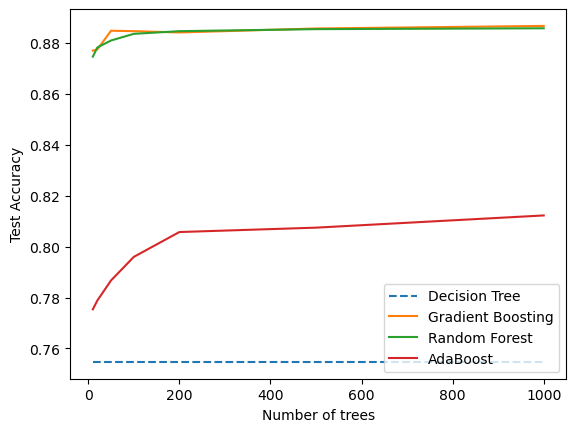

In [22]:
# Plot Accuracy for different Boosting Algorithm
plt.plot(n_trees, DecisionTree_acc, "--", label="Decision Tree")
plt.plot(n_trees, GB_acc, label= "Gradient Boosting")
plt.plot(n_trees, RF_acc, label = "Random Forest")
plt.plot(n_trees, Ada_acc, label= "AdaBoost")
plt.xlabel("Number of trees")
plt.ylabel("Test Accuracy")
plt.legend(loc="best")
plt.show()

For Adaboost, as the number of estimators increases, the accuracy also increases accordingly. But if the number of trees exceeds 200, the accuracy plateaued at around 0.81. 

Gradient boosting and Random Forest performed similarly, with an accuracy around 0.88.

#### Feature Importance Analysis

In [29]:
# Run final model to check feature importances

Adaclf = AdaBoostClassifier(n_estimators=200, algorithm="SAMME").fit(X_train, y_train)
GBclf = GradientBoostingClassifier(n_estimators=200, **grid_GB.best_params_).fit(X_train, y_train)
RFclf = RandomForestClassifier(n_estimators=200, **grid_RF.best_params_).fit(X_train, y_train)

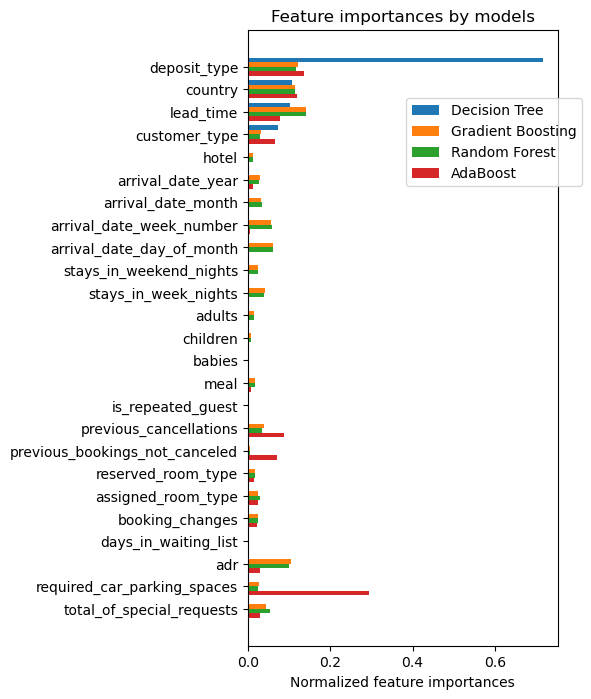

In [42]:
dtfi= list(zip(DecisionTreeclf.feature_names_in_, DecisionTreeclf.feature_importances_))
dtfi= sorted(dtfi, reverse=True, key= lambda x: x[1])

sortedFeatures = [x[0] for x in dtfi]

GBfi= dict(zip(GBclf.feature_names_in_, GBclf.feature_importances_))
RFfi= dict(zip(RFclf.feature_names_in_, RFclf.feature_importances_))
adafi= dict(zip(Adaclf.feature_names_in_, Adaclf.feature_importances_))
dtfi= dict(zip(DecisionTreeclf.feature_names_in_, DecisionTreeclf.feature_importances_))

featureImportances = {
    'Gradient Boosting': [GBfi[x] for x in sortedFeatures],
    'Random Forest': [RFfi[x] for x in sortedFeatures],
    'AdaBoost': [adafi[x] for x in sortedFeatures],
    'Decision Tree': [dtfi[x] for x in sortedFeatures], 
}

y = np.arange(len(sortedFeatures)-1, -1, -1)  # the label locations
width = 0.2  # the width of the bars
multiplier = len(featureImportances)-1

fig, ax = plt.subplots(figsize=(4,8))

for model in ["Decision Tree", "Gradient Boosting", "Random Forest", "AdaBoost"]:
    offset = width * multiplier
    rects = ax.barh(y + offset, featureImportances[model], width, label=model)
    # ax.bar_label(rects, padding=3)
    multiplier -= 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Normalized feature importances')
ax.set_title('Feature importances by models')
ax.set_yticks(y + 1.5*width, sortedFeatures)
ax.legend(bbox_to_anchor=(1.1, 0.9))

plt.show()

#### Results and Analysis
- Performance improvement approaches: For Decision Tree Classifier, I calculated and compared the accuracy corresponding to multiple ccp_alpha values to find the most appropriate ccp_alpha value, which is 0.01; For emsemble models, I employed GridSearchCV to select the best parameter combination for each model.
- Performance comparison: Decision Tree Classifier has a good performance of Accuracy=0.75 and AUC=0.80; All three ensemble models do much better than that. For this dataset with a small number of features (118897 samples, 25 features), Gradient Boost Classifier performs better than Adaboost Classifier. However there is no significant performance difference between Gradient Boost Classifier and Random Forest Classifier (test accuracy for both is around 88%), and the optimal "n_estimators" parameter is around 100 for both classifiers.
- Feature importance: With n_estimators=200 (which is the value when the accuracy for all four models is saturating), the top 3 most important features for the models are "deposit_type", "country", and "lead_time". The results are consistent with the correlation heatmap obtained during the EDA process.

## 4. Discussion and Conclusion

In this project, my main goal is to train a predictive model to classify whether a hotel booking will be cancelled. This project took me through the typical machine learning process that a professional data scientist would do. I learned a lot from this experience. 

First, I found that the most time I spent on this project was looking for data with a sufficient sample size, rich information, and interest. Exploratory data analysis also took a lot of my time because it is a fundamental step in fully understanding the data. During the EDA process, from the perspective of the correlation matrix, only a few features have a certain correlation with cancellation. But later the supervised machine learning models successfully predicted cancellations with relatively high accuracy.

Another takeaway is to choose an appropriate model for your data and then try multiple models to see if there is a better solution. Taking this project as an example, since my goal is to make prediction with yes or no values, a classification model is better than a regression model. Therefore, I decided to train decision tree, learn to use several parameter selection methods, such as calculating the accuracy of multiple hyperparameter ccp_alpha values and perform GridSearchCV, and develop several ensemble models to prevent overfitting and obtain better performance.

In addition, it is a good comparative analysis to conduct feature importance analysis on the optimized models and review the data analysis conclusions in EDA process. The model feature importance analysis results of this project are consistent with the correlation matrix results in EDA.

Finally, there are also some interesting analyzes that could be included or improved in future work. For example, as mentioned earlier, non-refundable deposit types have higher cancellation rate than other deposit types. We can improve our model and see if we can find the cause of this phenomenon. Also we can develop models to answer more questions about this data, such as when is the best time to book a hotel to get the best deal, or if some booking requirement settings can be made to reduce cancellation.

Overall, this project was a comprehensive learning experience for me in supervised model training. I appreciate it.